<a href="https://colab.research.google.com/github/InowaR/colab/blob/main/PointCloudFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Генерация первого прямоугольника (target)...
Генерация второго прямоугольника (source)...
Добавление выбросов...
Классификация точек...

=== СТАТИСТИКА ===
Всего точек в target (первый прямоугольник): 200
Всего точек в source (второй прямоугольник): 210
  - Исходных точек прямоугольника: 180
  - Добавлено выбросов: 30

Классификация точек source:
  - Перекрывающихся точек: 175 (83.3%)
  - Выбросов: 35 (16.7%)

Создание визуализации...


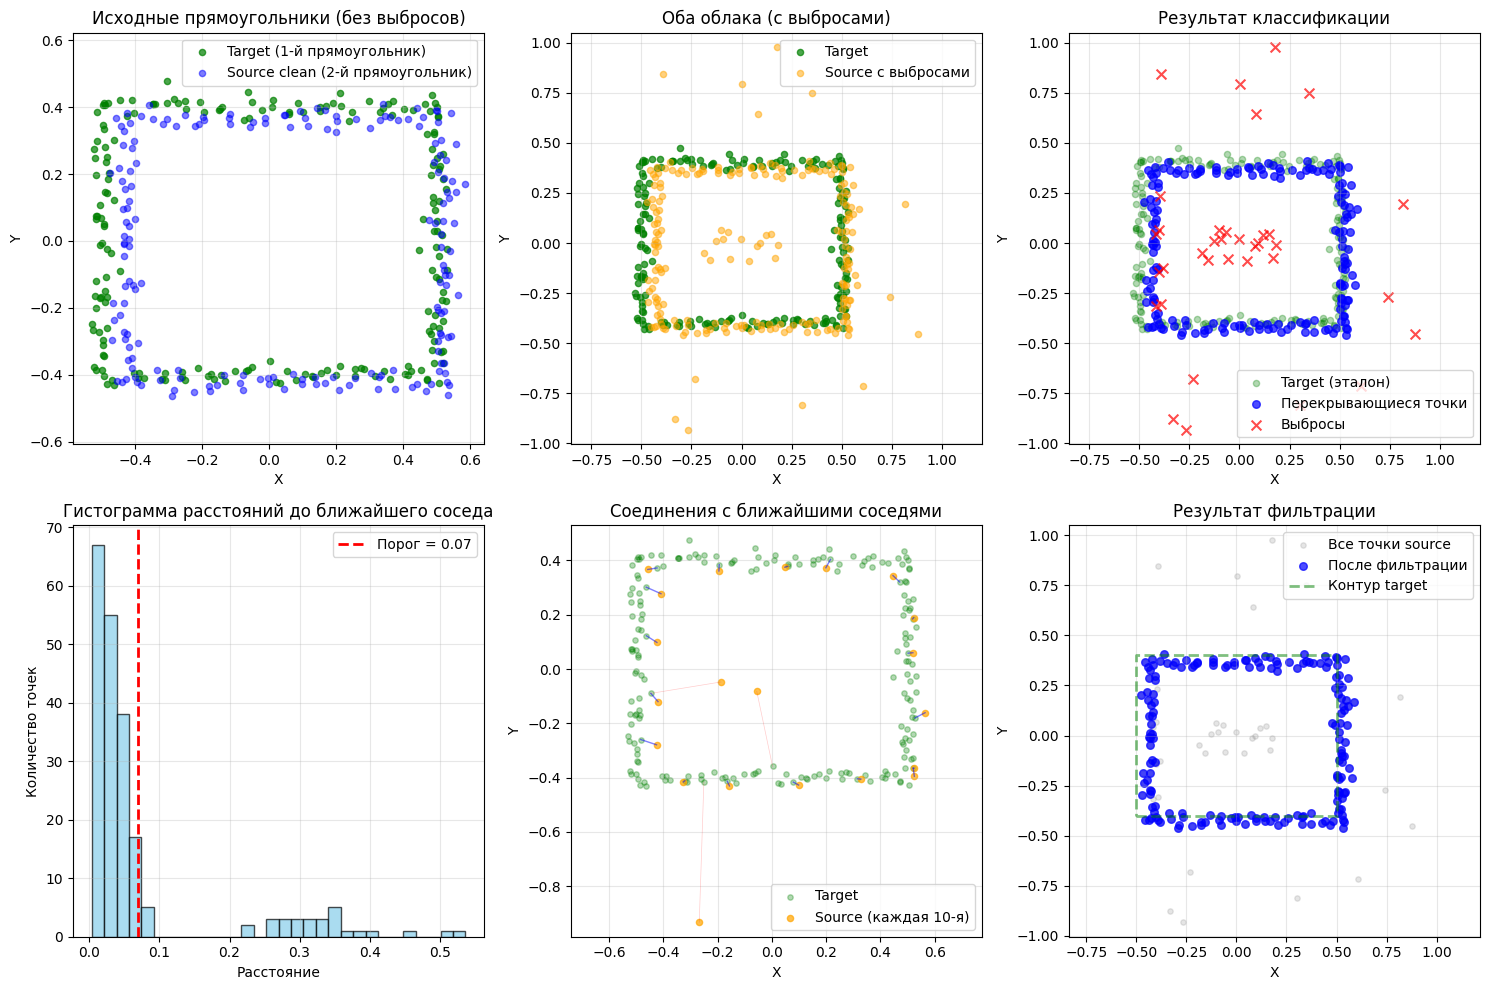


=== ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ ===
Цветовая схема:
  ЗЕЛЕНЫЙ: Точки первого прямоугольника (target)
  СИНИЙ: Точки второго прямоугольника, которые перекрываются с первым
  КРАСНЫЙ: Выбросы (не перекрываются с первым прямоугольником)
  ОРАНЖЕВЫЙ: Исходные точки второго прямоугольника
  СЕРЫЙ: Все точки второго прямоугольника (в сравнении)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def generate_rectangle_points(center, width, height, num_points, noise_scale=0.02):
    """
    Генерирует точки прямоугольника с шумом
    """
    # Создаем равномерно распределенные точки по периметру прямоугольника
    points_per_side = num_points // 4

    # Верхняя сторона
    x_top = np.linspace(center[0] - width/2, center[0] + width/2, points_per_side)
    y_top = np.full(points_per_side, center[1] + height/2)

    # Правая сторона
    x_right = np.full(points_per_side, center[0] + width/2)
    y_right = np.linspace(center[1] - height/2, center[1] + height/2, points_per_side)

    # Нижняя сторона
    x_bottom = np.linspace(center[0] + width/2, center[0] - width/2, points_per_side)
    y_bottom = np.full(points_per_side, center[1] - height/2)

    # Левая сторона
    x_left = np.full(points_per_side, center[0] - width/2)
    y_left = np.linspace(center[1] + height/2, center[1] - height/2, points_per_side)

    # Объединяем все точки
    x = np.concatenate([x_top, x_right, x_bottom, x_left])
    y = np.concatenate([y_top, y_right, y_bottom, y_left])

    # Добавляем шум
    x_noise = x + np.random.normal(0, noise_scale, len(x))
    y_noise = y + np.random.normal(0, noise_scale, len(y))

    # Собираем в массив 2D точек
    points = np.column_stack([x_noise, y_noise])

    return points

def add_outliers(rectangle_points, num_outliers, outlier_range=0.5):
    """
    Добавляет выбросы к точкам прямоугольника
    """
    # Внутренние выбросы (внутри прямоугольника)
    num_internal = num_outliers // 2
    internal_outliers = np.random.uniform(
        low=[-0.2, -0.1],  # немного внутри прямоугольника
        high=[0.2, 0.1],
        size=(num_internal, 2)
    )

    # Внешние выбросы (снаружи прямоугольника)
    num_external = num_outliers - num_internal
    external_outliers = []

    # Генерируем внешние выбросы в разных направлениях
    for _ in range(num_external):
        # Случайный угол и расстояние
        angle = np.random.uniform(0, 2*np.pi)
        distance = np.random.uniform(0.6, 1.0)  # за пределами прямоугольника
        x = distance * np.cos(angle)
        y = distance * np.sin(angle)
        external_outliers.append([x, y])

    external_outliers = np.array(external_outliers)

    # Объединяем все выбросы
    all_outliers = np.vstack([internal_outliers, external_outliers])

    # Объединяем с исходными точками
    all_points = np.vstack([rectangle_points, all_outliers])

    return all_points, all_outliers

def classify_overlap_points(source_points, target_points, threshold=0.05):
    """
    Классифицирует точки source_points на перекрывающиеся и выбросы
    на основе расстояния до ближайшей точки в target_points
    """
    # Используем метод ближайших соседей
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(target_points)
    distances, indices = nbrs.kneighbors(source_points)

    # Классификация
    distances = distances.flatten()
    overlap_mask = distances < threshold

    # Создаем массивы для каждой категории
    overlap_points = source_points[overlap_mask]
    outlier_points = source_points[~overlap_mask]

    return overlap_points, outlier_points, overlap_mask

def main():
    # Параметры
    np.random.seed(42)  # для воспроизводимости

    # Генерация первого прямоугольника (исходное облако)
    print("Генерация первого прямоугольника (target)...")
    target_points = generate_rectangle_points(
        center=[0, 0],
        width=1.0,
        height=0.8,
        num_points=200,
        noise_scale=0.02
    )

    # Генерация второго прямоугольника (немного смещенного)
    print("Генерация второго прямоугольника (source)...")
    source_clean = generate_rectangle_points(
        center=[0.05, -0.03],  # небольшое смещение
        width=0.95,  # небольшое изменение размера
        height=0.78,
        num_points=180,
        noise_scale=0.02
    )

    # Добавляем выбросы ко второму прямоугольнику
    print("Добавление выбросов...")
    source_points, outliers_added = add_outliers(
        source_clean,
        num_outliers=30,  # 15 внутренних + 15 внешних выбросов
        outlier_range=1.0
    )

    # Классификация точек второго прямоугольника
    print("Классификация точек...")
    overlap_points, outlier_points, overlap_mask = classify_overlap_points(
        source_points,
        target_points,
        threshold=0.07  # порог для определения перекрытия
    )

    # Статистика
    print("\n=== СТАТИСТИКА ===")
    print(f"Всего точек в target (первый прямоугольник): {len(target_points)}")
    print(f"Всего точек в source (второй прямоугольник): {len(source_points)}")
    print(f"  - Исходных точек прямоугольника: {len(source_clean)}")
    print(f"  - Добавлено выбросов: {len(outliers_added)}")
    print(f"\nКлассификация точек source:")
    print(f"  - Перекрывающихся точек: {len(overlap_points)} ({len(overlap_points)/len(source_points)*100:.1f}%)")
    print(f"  - Выбросов: {len(outlier_points)} ({len(outlier_points)/len(source_points)*100:.1f}%)")

    # Визуализация
    print("\nСоздание визуализации...")
    plt.figure(figsize=(15, 10))

    # 1. Исходная визуализация
    plt.subplot(2, 3, 1)
    plt.scatter(target_points[:, 0], target_points[:, 1],
                c='green', s=20, alpha=0.7, label='Target (1-й прямоугольник)')
    plt.scatter(source_clean[:, 0], source_clean[:, 1],
                c='blue', s=20, alpha=0.5, label='Source clean (2-й прямоугольник)')
    plt.title('Исходные прямоугольники (без выбросов)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')

    # 2. Target + Source с выбросами
    plt.subplot(2, 3, 2)
    plt.scatter(target_points[:, 0], target_points[:, 1],
                c='green', s=20, alpha=0.7, label='Target')
    plt.scatter(source_points[:, 0], source_points[:, 1],
                c='orange', s=20, alpha=0.5, label='Source с выбросами')
    plt.title('Оба облака (с выбросами)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')

    # 3. Классификация точек
    plt.subplot(2, 3, 3)
    plt.scatter(target_points[:, 0], target_points[:, 1],
                c='green', s=20, alpha=0.3, label='Target (эталон)')
    plt.scatter(overlap_points[:, 0], overlap_points[:, 1],
                c='blue', s=30, alpha=0.7, label='Перекрывающиеся точки')
    plt.scatter(outlier_points[:, 0], outlier_points[:, 1],
                c='red', s=50, alpha=0.7, marker='x', label='Выбросы')
    plt.title('Результат классификации')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')

    # 4. Гистограмма расстояний
    plt.subplot(2, 3, 4)
    nbrs = NearestNeighbors(n_neighbors=1).fit(target_points)
    distances, _ = nbrs.kneighbors(source_points)
    distances = distances.flatten()

    plt.hist(distances, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(x=0.07, color='red', linestyle='--', linewidth=2,
                label=f'Порог = {0.07}')
    plt.title('Гистограмма расстояний до ближайшего соседа')
    plt.xlabel('Расстояние')
    plt.ylabel('Количество точек')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5. Визуализация метода ближайших соседей
    plt.subplot(2, 3, 5)
    # Показываем некоторые соединения для наглядности
    nbrs = NearestNeighbors(n_neighbors=1).fit(target_points)
    distances, indices = nbrs.kneighbors(source_points)

    plt.scatter(target_points[:, 0], target_points[:, 1],
                c='green', s=15, alpha=0.3, label='Target')

    # Показываем только часть соединений для наглядности
    for i in range(0, len(source_points), 10):  # Каждая 10-я точка
        source_pt = source_points[i]
        target_pt = target_points[indices[i][0]]

        # Разный цвет в зависимости от расстояния
        color = 'blue' if distances[i][0] < 0.07 else 'red'
        linewidth = 1.0 if distances[i][0] < 0.07 else 0.5
        alpha = 0.5 if distances[i][0] < 0.07 else 0.2

        plt.plot([source_pt[0], target_pt[0]],
                 [source_pt[1], target_pt[1]],
                 color=color, linewidth=linewidth, alpha=alpha)

    plt.scatter(source_points[::10, 0], source_points[::10, 1],
                c='orange', s=20, alpha=0.7, label='Source (каждая 10-я)')

    plt.title('Соединения с ближайшими соседями')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')

    # 6. Сравнение до и после фильтрации
    plt.subplot(2, 3, 6)
    plt.scatter(source_points[:, 0], source_points[:, 1],
                c='gray', s=15, alpha=0.2, label='Все точки source')
    plt.scatter(overlap_points[:, 0], overlap_points[:, 1],
                c='blue', s=30, alpha=0.7, label='После фильтрации')

    # Контур исходного прямоугольника для наглядности
    rect_x = [-0.5, 0.5, 0.5, -0.5, -0.5]
    rect_y = [-0.4, -0.4, 0.4, 0.4, -0.4]
    plt.plot(rect_x, rect_y, 'g--', linewidth=2, alpha=0.5, label='Контур target')

    plt.title('Результат фильтрации')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')

    plt.tight_layout()
    plt.show()

    # Дополнительная информация
    print("\n=== ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ ===")
    print("Цветовая схема:")
    print("  ЗЕЛЕНЫЙ: Точки первого прямоугольника (target)")
    print("  СИНИЙ: Точки второго прямоугольника, которые перекрываются с первым")
    print("  КРАСНЫЙ: Выбросы (не перекрываются с первым прямоугольником)")
    print("  ОРАНЖЕВЫЙ: Исходные точки второго прямоугольника")
    print("  СЕРЫЙ: Все точки второго прямоугольника (в сравнении)")

if __name__ == "__main__":
    main()